[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Groaaaar/SimpleClassifier/blob/main/Ambiance-Product-Schema.ipynb)


# Imports

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns           
import numpy as np              
import pandas as pd             
import os                 
import shutil
from functools import partial
import zipfile
import random                   
from PIL import Image      


# Are we in Colab or Jupyter ?

In [2]:
import sys
in_colab = "google.colab" in sys.modules
if in_colab:
    print("We are in colab")
else:
    print("We are not in colab")


We are not in colab


# Preprocess data or download data (colab)
In order to avoid messy files names, when in Jupyter we copy all files from each folder under `CARREFOUR` to `DATA` with a simpler file name

## Jupyter

In [3]:
data_folder = "DATA"
if not in_colab:
    source_folder = "CARREFOUR"
    if not os.path.exists(data_folder):
        os.mkdir(data_folder)
    labels = os.listdir(source_folder)
    for l in labels:
        src_dir = os.path.join(source_folder,l)
        dest_dir = os.path.join(data_folder,l)
        if not os.path.exists(dest_dir):
            os.mkdir(dest_dir)
        files = os.listdir(src_dir)
        for i,f in enumerate(files):
            name = 'file' + str(i) + f[f.rfind("."):]
            shutil.copyfile(os.path.join(src_dir,f),os.path.join(dest_dir,name))



## Colab

In [4]:
if in_colab:
    !wget https://github.com/Groaaaar/Product-Ambiance-Sketch/raw/main/DATA.zip
    !unzip DATA.zip    


In [ ]:
if in_colab:
    !wget https://github.com/Groaaaar/Product-Ambiance-Sketch/raw/main/TEST.zip
    !unzip TEST.zip  

`labels` and `data_folder` contains respectively the list of labels and the name of the folder containing pictures. Pictures are in subfolders corresponding to the name of the label

In [6]:
labels = sorted(os.listdir(data_folder))
labels

['AMBIANCE', 'PRODUCT', 'SKETCH']

# Define a few functions to load and transform pictures
* `load_pic` : load picture as numpy array in 3D (X,Y,Color)
* `normalize pic` : normalize the colors. Round all RGB code to 0.1 (RGB normalized to [0,1]
* `conv` : transformation to compute a metric showing the variation between a pixel and its neighbours
* `pixelise` : pixelise a picture in 5x5 pixel bloacks
* `crop` : take the external  pixels around the image
* `visualize_sample` : pick a random sample belonging to a label and compare it with the transformed pictures

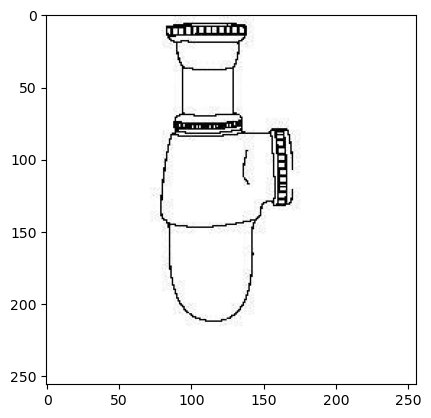

In [7]:
def load_pic(*args,size=256):
    """
    Load a picture, resize it (size*size) - (256,256) by default, resolve conversion issues, 
    normalize it [0,1]. Takes the path as input and return a numpy array. If the image has a transparency,
    the transparency will be ignored
    """
    pic = Image.open(os.path.join(*args))
    pic = pic.resize((size,size))
    array = np.array(pic)
    if array.ndim==2:
        array = np.stack([array,array,array],axis=2)
    if array.shape[2]==4:
        array = array[:,:,0:3]
    return array/255.0
    
        
plt.imshow(load_pic(data_folder,labels[2],'file53.PNG'));

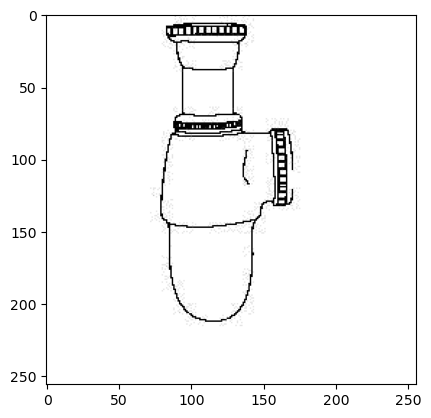

In [8]:
def normalize_pic(pic, dec=1):
    """
    normalize the colors to avoid 'dust' effect. Rounds to 'dec' numbers (1 by default).
    """
    pic = np.round(pic*10**dec,decimals=0)/10**dec
    return pic

plt.imshow(normalize_pic(load_pic(data_folder,labels[2],'file53.PNG')));


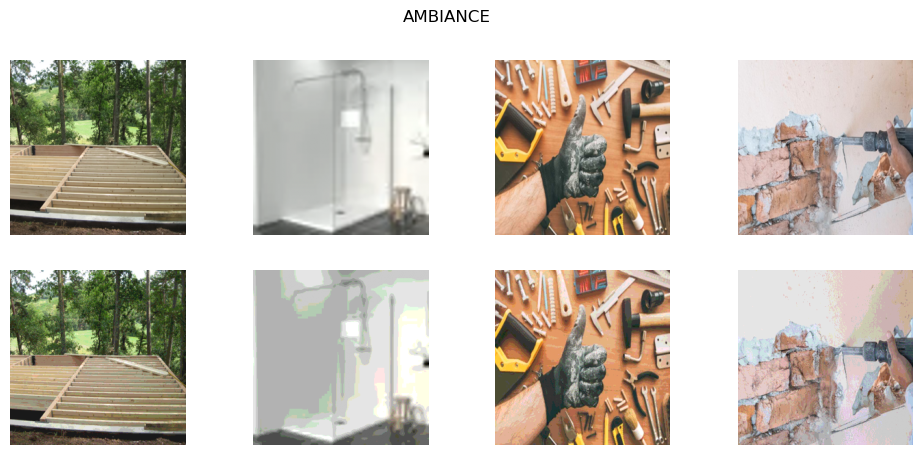

In [9]:
def visualize_sample(l, func=None):
    """
    Visualize 8 pictures. If no transformation function is chosen, choose 8 random picture from the choosen label.
    If a transformation is chosen then choose 4 pictures and display the pictures and the transformed pictures
    """
    plt.figure(figsize=(12,5))
    plt.suptitle(l)
    vis_dir =  os.path.join(data_folder,l)
    pics = os.listdir(vis_dir)
    if func:
        pics = random.sample(pics,4)
        for i,f in enumerate(pics):
            im = load_pic(vis_dir,f)
            for j in range(2):
                plt.subplot(2,4,i+1+4*j)
                plt.gca().axis('off')
                plt.imshow(im)
                im=func(im)
    else:
        pics = random.sample(pics,8)
        for i,f in enumerate(pics):    
            plt.subplot(2,4,i+1)
            im = load_pic(vis_dir,f)
            plt.gca().axis('off')
            plt.imshow(im)
    
visualize_sample(labels[0],normalize_pic)


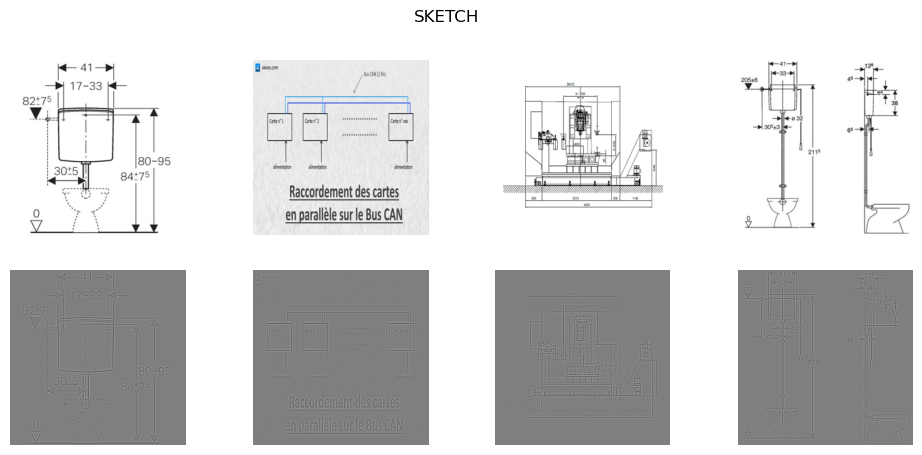

In [10]:
def conv(pic):
    """
    Apply a home-brew convolution. The function expects pic to be normalized (0,1). It will compute each pixels as the pixels
    minus the average value of surrounding pixels (pixels above, below, on the right and on the left). In order ot have a mean 
    color at 0.5, each color is computed as:
    0.5 + pixels - 0.25 x (below+above+right+left)
    
    """
    my_array = np.array(pic,dtype=float)
    my_array = (my_array[1:-1,1:-1] - 0.25*(my_array[1:-1,2:]+my_array[1:-1,:-2]+
                                          my_array[2:,1:-1]+my_array[:-2,1:-1]))/2 + 0.5
    my_array[my_array<0] = 0
    return my_array 
visualize_sample(labels[2],conv)

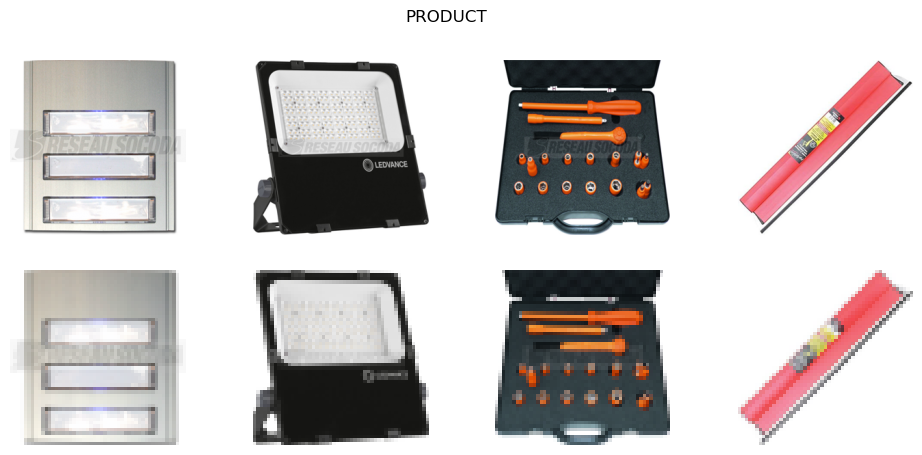

In [11]:
def pixelise_pic(pic, pixels=5):
    """
    Take each block of pixels (5 by defaut), average its value and inject as a single pixel in the returned image. The
    size of the returned image is thus the original size // pixels.
    """
    dim = np.array(pic.shape)
    dim = pixels * (dim//pixels)
    blocked_matrix = np.reshape(pic[0:dim[0],0:dim[1]], (dim[0]//pixels, pixels, dim[1]//pixels, pixels,3)).mean(axis=(1,3))
    return blocked_matrix
visualize_sample(labels[1],pixelise_pic)

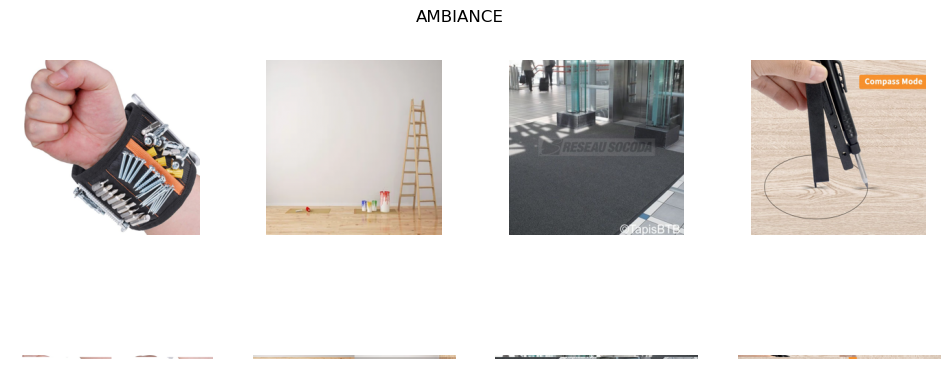

In [12]:
def crop(pic,pixels=5):
    """
    Extract a borders of 'pixels' pixels. The returned image is computed by the following algorithm:
      1 Stack vertically the top and bottom border
      2.Transpose the right and left borders and stack the outputs vertically
      3. Stack horizontally 1 and 2
    The output is a picture of 2x'pixels' pixels high and  (length+height-pixels) wide
    """
    hor = np.vstack((pic[:pixels,:,:],pic[-pixels:,:,:]))
    ver = np.vstack((pic[:,:pixels,:].transpose([1,0,2]),pic[:,-pixels:,:].transpose([1,0,2])))
    return np.hstack((hor,ver))
visualize_sample(labels[0],crop)

# Stats 
## Get statistics from images
We will gather statistics from pictures : 
- mean value across pixels (darkness)
- standard deviation across pixels
- how many different colors are there in the picture ?

We first take a random image from each label

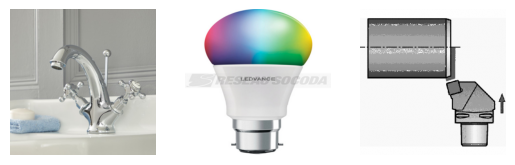

In [13]:
test=[None for i in range(len(labels))]
for i in range(len(labels)):
    pic = random.choice(os.listdir(os.path.join(data_folder,labels[i])))
    test[i] = load_pic(data_folder,labels[i],pic)
    plt.subplot(1,3,i+1)
    plt.gca().axis('off')
    plt.imshow(test[i])


We then count the amount of colors and display it for each picture

In [14]:
def get_colors(pic):
    """
    Return the different colors in a picture (RGB)
    """
    dim = pic.shape
    return np.unique(np.resize(pic,(dim[0]*dim[1],3)),axis=0)

def visualise_colors(pic):
    """
    Visualise all colors in a pic
    """
    pic = get_colors(pic)
    pic = np.resize(pic,(pic.shape[0]//50+1,pic.shape[0],3))
    plt.imshow(pic)
    plt.gca().axis('off')
    plt.show()
    
def get_q_colors(pic):
    """
    Return the quantity of different colors in a picture
    """
    dim = pic.shape
    return len(np.unique(np.resize(pic,(dim[0]*dim[1],3)),axis=0))
for i in test:
    print (get_q_colors(i), "Different colors")
    visualise_colors(i)

10608 Different colors


16640 Different colors


250 Different colors


In [15]:
# for i in test:
#     print (get_q_colors(normalize_pic(i)))
#     visualise_colors(normalize_pic(i))

In [16]:
# for i in test:
#     print (get_q_colors(conv(i)))
#     visualise_colors(conv(i))

In [17]:
# for i in test:
#     print (get_q_colors(pixelise_pic(i)))
#     visualise_colors(pixelise_pic(i))

Let's build our features:
* mean
* standard deviation
* amount of different color   
for the picture, the normalized picture, the pixelized picture and the the pixelised convolution.

`get_stats` will compute the mean, std and q color of a picture and return it as a list.

In [18]:
def get_stats(pic):
    """
    Return a list containing at index 
    - 0: mean value of the pixels of the pciture
    - 1: std deviation of the pixels of the pciture
    - 2: the amount of different colors in the picture
    """
    output = []
    output.append(pic.mean())
    output.append(pic.std())
    output.append(get_q_colors(pic))
    return output

## Important dictionnaries & list:
* `stats` is list containing labels corresponding to the values computed by `get_stats`
* `transformations` is a dictionary mapping a description of a transformation (short string) to the transformation function
(actual function to be executed on the picture)

We then use the nomenclature `transformation_stats` for our features

In [19]:
def no_function(input):
    return input

stats = ['mean','std','q_col']

transformations = {
    'base': no_function,
    'norm': normalize_pic,
    'pix': pixelise_pic,
    'conv': lambda x:conv(normalize_pic(x)),
    'crop': crop,   
    'cr_n' : lambda x:crop(normalize_pic(x)),
    'cr_p' : lambda x:crop(pixelise_pic(x)),
    'cr_c' : lambda x:crop(conv(normalize_pic(x))),
}

base


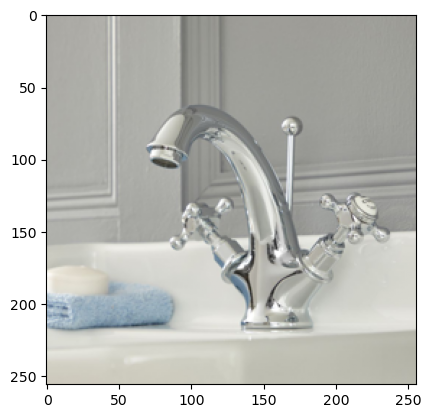

norm


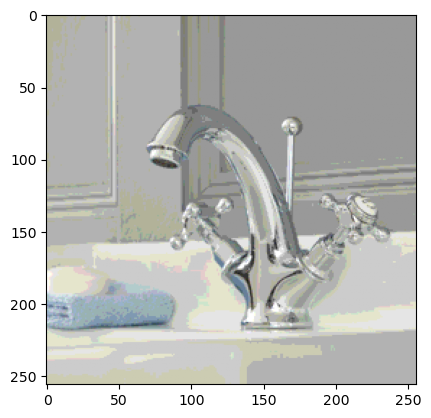

pix


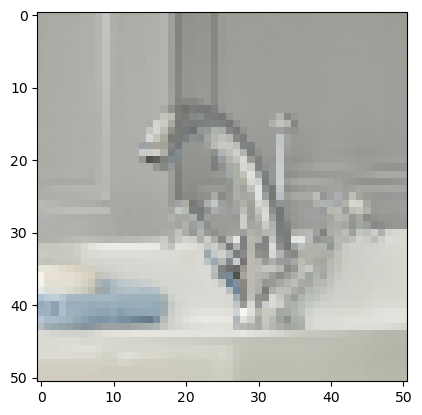

conv


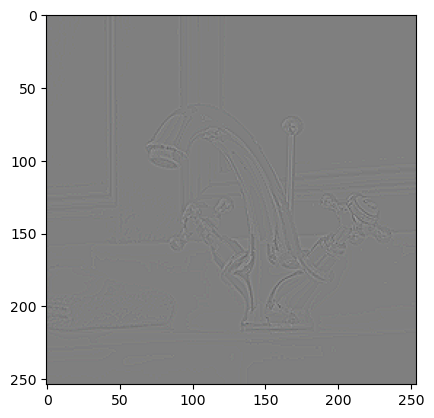

crop


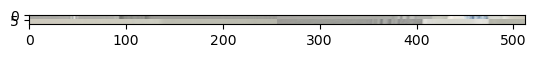

cr_n


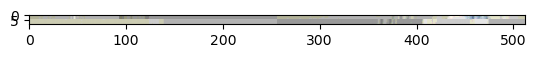

cr_p


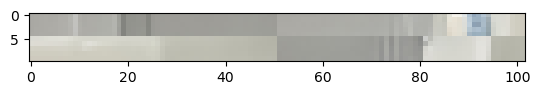

cr_c


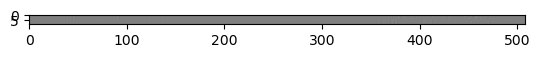

In [20]:
for i in transformations:
    print(i)
    plt.imshow(transformations[i](test[0]))
    plt.show()

`columns` contains all labels generated by combining `transformations` and `stats`

In [21]:
X = []
columns=['label','path'] + [i+"_"+j for i in transformations for j in stats]

for i in range(len(labels)):
    files = os.listdir(os.path.join(data_folder,labels[i]))
    for f in files:
        pic = load_pic(data_folder,labels[i],f)
        row = [labels[i],os.path.join(data_folder,labels[i],f)]
        for t in transformations:
            row = row + get_stats(transformations[t](pic))
        X.append(row)


In [22]:
data = pd.DataFrame(data=X,columns=columns)

In [23]:
data

label                       path  base_mean  base_std  base_q_col  \
0    AMBIANCE   DATA\AMBIANCE\file0.webp   0.701772  0.341263       23515   
1    AMBIANCE    DATA\AMBIANCE\file1.jpg   0.467570  0.214853       17011   
2    AMBIANCE  DATA\AMBIANCE\file10.webp   0.762891  0.151005        5899   
3    AMBIANCE   DATA\AMBIANCE\file11.jpg   0.544305  0.283279       52169   
4    AMBIANCE  DATA\AMBIANCE\file12.webp   0.805208  0.110205       12153   
..        ...                        ...        ...       ...         ...   
205    SKETCH     DATA\SKETCH\file68.png   0.003076  0.013830          42   
206    SKETCH     DATA\SKETCH\file69.jpg   0.932764  0.127532        2702   
207    SKETCH      DATA\SKETCH\file7.jpg   0.972399  0.133189        2595   
208    SKETCH     DATA\SKETCH\file8.webp   0.980812  0.087918         334   
209    SKETCH     DATA\SKETCH\file9.webp   0.980812  0.087918         334   

     norm_mean  norm_std  norm_q_col  pix_mean   pix_std  ...  crop_q_col  \
0     0.701803  0.343380         112  0.699429  0.336154  ...           4   
1     0.467306  0.217060          94  0.466275  0.197053  ...        1989   
2     0.758765  0.155335          45  0.764290  0.146581  ...        1099   
3     0.545576  0.285813         270  0.543513  0.253225  ...        4412   
4     0.804441  0.114219         133  0.805907  0.105584  ...        1556   
..         ...       ...         ...       ...       ...  ...         ...   
205   0.002023  0.014284           3  0.003100  0.008682  ...           1   
206   0.931523  0.128941          45  0.932243  0.085097  ...         128   
207   0.974575  0.132915          61  0.972193  0.117735  ...           3   
208   0.980899  0.088477          16  0.980661  0.057875  ...          21   
209   0.980899  0.088477          16  0.980661  0.057875  ...          21   

     cr_n_mean  cr_n_std  cr_n_q_col  cr_p_mean  cr_p_std  cr_p_q_col  \
0     1.000000  0.000000           1   0.941474  0.197232         193   
1     0.536257  0.229231          58   0.504376  0.206458         917   
2     0.695091  0.233908          34   0.709454  0.201263         820   
3     0.607324  0.289426         150   0.594020  0.263625         920   
4     0.772389  0.115256          26   0.775928  0.117110         867   
..         ...       ...         ...        ...       ...         ...   
205   0.000000  0.000000           1   0.001547  0.007304          53   
206   0.950228  0.087767           7   0.952550  0.067180         340   
207   1.000000  0.000000           1   0.998742  0.001428          29   
208   0.999063  0.010964           4   0.990596  0.054228          33   
209   0.999063  0.010964           4   0.990596  0.054228          33   

     cr_c_mean  cr_c_std  cr_c_q_col  
0     0.500000  0.000000           1  
1     0.499856  0.014761         463  
2     0.500107  0.008484         196  
3     0.499870  0.034104        1557  
4     0.499893  0.008051         240  
..         ...       ...         ...  
205   0.500000  0.000000           1  
206   0.499395  0.030708          43  
207   0.500000  0.000000           1  
208   0.500080  0.005645          20  
209   0.500080  0.005645          20  

[210 rows x 26 columns]

In [24]:
data.label.value_counts()

AMBIANCE    70
PRODUCT     70
SKETCH      70
Name: label, dtype: int64

In [25]:
data.join(pd.get_dummies(data['label'])).corr()[['AMBIANCE','PRODUCT','SKETCH']]


AMBIANCE   PRODUCT    SKETCH
base_mean  -0.223666  0.168145  0.055521
base_std    0.165384  0.273975 -0.439359
base_q_col  0.696024 -0.114892 -0.581132
norm_mean  -0.223631  0.168294  0.055337
norm_std    0.169311  0.272262 -0.441572
norm_q_col  0.472364 -0.036251 -0.436113
pix_mean   -0.222075  0.164914  0.057161
pix_std     0.206646  0.335410 -0.542056
pix_q_col   0.672796  0.020021 -0.692817
conv_mean   0.018863 -0.183614  0.164751
conv_std    0.016279 -0.311171  0.294892
conv_q_col  0.563685 -0.043357 -0.520328
crop_mean  -0.323405  0.426757 -0.103352
crop_std    0.443603 -0.220338 -0.223265
crop_q_col  0.779799 -0.316264 -0.463535
cr_n_mean  -0.323342  0.426188 -0.102846
cr_n_std    0.447245 -0.220004 -0.227241
cr_n_q_col  0.678625 -0.271404 -0.407220
cr_p_mean  -0.271357  0.304487 -0.033130
cr_p_std    0.317834  0.099039 -0.416874
cr_p_q_col  0.710945 -0.181211 -0.529734
cr_c_mean  -0.006405 -0.118060  0.124465
cr_c_std    0.266613 -0.259947 -0.006667
cr_c_q_col  0.697504 -0.265206 -0.432298
AMBIANCE    1.000000 -0.500000 -0.500000
PRODUCT    -0.500000  1.000000 -0.500000
SKETCH     -0.500000 -0.500000  1.000000

# Model with sklearn SVC

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

## Train and evaluate accuracy on train set

In [27]:
y_train = data['label']
X_train = data.iloc[:,2:]

In [28]:
steps = [('scaler', StandardScaler()),
         ('svm', SVC(kernel='rbf', C=100, probability=True))]
classifier = Pipeline(steps)
classifier.fit(X_train,y_train)
preds = classifier.predict(X_train)
probs = classifier.predict_proba(X_train)

In [29]:
print(f"Accuracy {100*accuracy_score(y_train,preds):.2f}%")

Accuracy 100.00%


## Review mistakes

In [30]:
wrong = data.loc[preds!=y_train,:]
for i in wrong.index:
    print(f"Predicted label: {preds[i]}\ttrue label: {wrong.loc[i,'label']} and proba: {probs[i]}")
    plt.figure(figsize=(5,5))
    plt.imshow(load_pic(wrong.loc[i,'path']))
    plt.axis("Off")
    plt.show()
    print("******************************************************\n\n")

## What confidence probabilities have we ?

<AxesSubplot:ylabel='Count'>

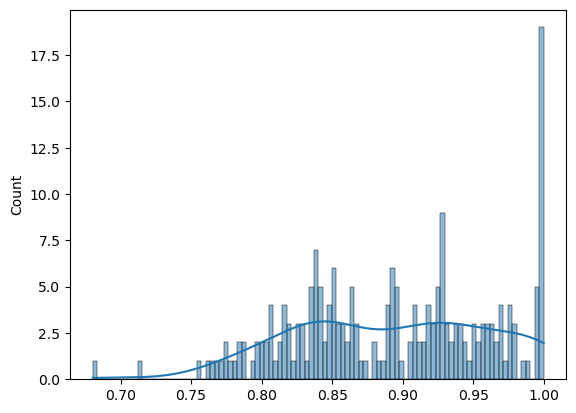

In [31]:
confidences = probs.max(axis=1)
sns.histplot(confidences,bins=100,kde=True)

In [32]:
np.percentile(confidences,[5*i for i in range(21)])


array([0.68035599, 0.78310867, 0.80330286, 0.81613203, 0.82998974,
       0.83899982, 0.84633919, 0.85417846, 0.8645921 , 0.88699743,
       0.89437308, 0.90925755, 0.92093287, 0.92832284, 0.93635045,
       0.9505632 , 0.96167496, 0.97491963, 0.99570671, 0.99882165,
       0.99999959])

## Use confidence to detect errors
We will use 70%

In [33]:
confidence_ratio = 0.7
wrong_detected = data[confidences<=confidence_ratio]
print(f"There are {len(wrong_detected)} classification with confidence below {100*confidence_ratio}% out of {len(data)} picture")

There are 1 classification with confidence below 70.0% out of 210 picture


Predicted label: AMBIANCE	true label: AMBIANCE and proba: [0.68035599 0.30323656 0.01640745]


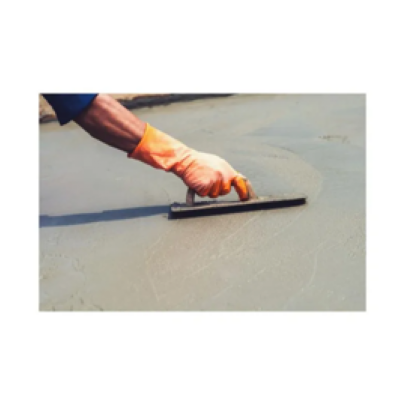

******************************************************




In [34]:

for i in wrong_detected.index:
    print(f"Predicted label: {preds[i]}\ttrue label: {wrong_detected.loc[i,'label']} and proba: {probs[i]}")
    plt.figure(figsize=(5,5))
    plt.imshow(load_pic(wrong_detected.loc[i,'path']))
    plt.axis("Off")
    plt.show()
    print("******************************************************\n\n")

## Test Set

In [35]:
X_test = []

files = os.listdir(os.path.join("./test"))
for f in files:
    pic = load_pic("./test",f)
    row = []        
    for t in transformations:
        row = row + get_stats(transformations[t](pic))
    X_test.append(row)
X_test = pd.DataFrame(X_test,columns=columns[2:])
pred_test = classifier.predict(X_test)
test_probs = classifier.predict_proba(X_test)


Prediction: AMBIANCE, proba [0.86885896 0.1125991  0.01854194]


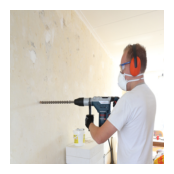

Prediction: PRODUCT, proba [0.23080939 0.75403616 0.01515444]


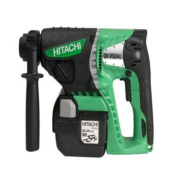

Prediction: AMBIANCE, proba [0.89871149 0.05921387 0.04207463]


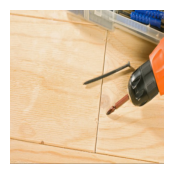

Prediction: SKETCH, proba [0.02089974 0.05698081 0.92211946]


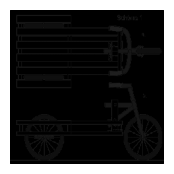

Prediction: PRODUCT, proba [0.18545773 0.78282518 0.03171709]


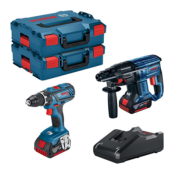

Prediction: PRODUCT, proba [0.06520997 0.90409344 0.03069659]


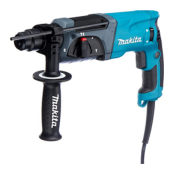

Prediction: PRODUCT, proba [0.05736881 0.8323671  0.1102641 ]


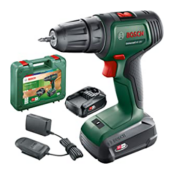

Prediction: AMBIANCE, proba [0.91575331 0.06259535 0.02165133]


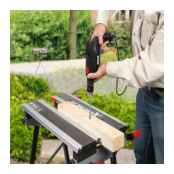

Prediction: AMBIANCE, proba [0.92958752 0.05844188 0.01197059]


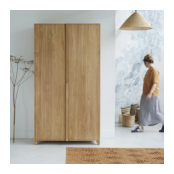

Prediction: SKETCH, proba [5.08358878e-03 3.20367527e-04 9.94596044e-01]


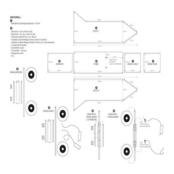

Prediction: PRODUCT, proba [0.03475325 0.95502059 0.01022616]


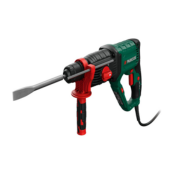

Prediction: AMBIANCE, proba [0.68026108 0.21268881 0.10705011]
Confidence ration below threshold


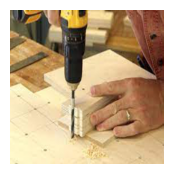

Prediction: SKETCH, proba [0.46059625 0.10204074 0.43736302]
Confidence ration below threshold


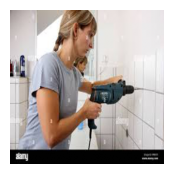

Prediction: AMBIANCE, proba [0.93251713 0.05136122 0.01612165]


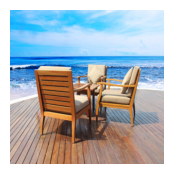

Prediction: SKETCH, proba [1.60937104e-03 4.10300452e-05 9.98349599e-01]


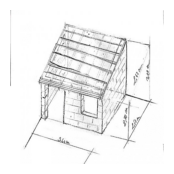

Prediction: PRODUCT, proba [0.02279561 0.9756911  0.00151328]


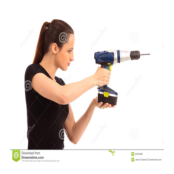

Prediction: PRODUCT, proba [0.20216557 0.78977789 0.00805654]


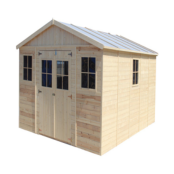

Prediction: SKETCH, proba [0.1073922  0.10536152 0.78724629]


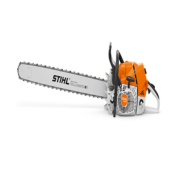

Prediction: AMBIANCE, proba [0.9190778  0.03168159 0.04924061]


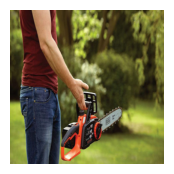

Prediction: SKETCH, proba [0.0259607  0.11116353 0.86287576]


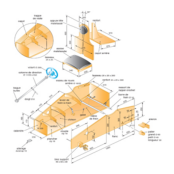

20 images in total


In [37]:
for i in range(len(files)):
    print(f"Prediction: {pred_test[i]}, proba {test_probs[i]}")
    if np.max(test_probs[i])<= confidence_ratio:
        print("Confidence ration below threshold")
    pic = load_pic("test",files[i])
    plt.figure(figsize=(2,2))
    plt.imshow(pic)
    plt.axis("Off")
    plt.show()
print(len(files),"images in total")

<div class="alert alert-block alert-danger">
    The SVM is making errors on the test set "with confidence". Likely in overfit
</div>

# Sklearn Random Forest

## Train and Accuracy

In [62]:
from sklearn.ensemble import RandomForestClassifier
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(max_depth=10))]
classifier = Pipeline(steps)
classifier.fit(X_train,y_train)
preds = classifier.predict(X_train)
probs = classifier.predict_proba(X_train)

In [63]:
print(f"Accuracy {100*accuracy_score(y_train,preds):.2f}%")

Accuracy 100.00%


## Errors ?

In [64]:
wrong = data.loc[preds!=y_train,:]
for i in wrong.index:
    print(f"Predicted label: {preds[i]}\ttrue label: {wrong.loc[i,'label']} and proba: {probs[i]}")
    plt.figure(figsize=(5,5))
    plt.imshow(load_pic(wrong.loc[i,'path']))
    plt.axis("Off")
    plt.show()
    print("******************************************************\n\n")

## Confidence

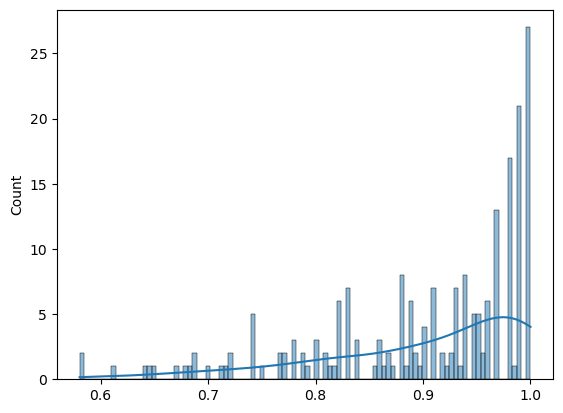

[0.5804     0.69409034 0.74969333 0.79377244 0.82       0.84
 0.87629195 0.88900615 0.9        0.92055759 0.93668333 0.94925517
 0.95896207 0.97       0.98       0.98       0.99       0.99
 1.         1.         1.        ]


In [65]:
confidences = probs.max(axis=1)
sns.histplot(confidences,bins=100,kde=True)
plt.show()
print(np.percentile(confidences,[5*i for i in range(21)]))

## Detect errors
We will use 0.65
$$$0.55

In [66]:
confidence_ratio = 0.65
wrong_detected = data[confidences<=confidence_ratio]
print(f"There are {len(wrong_detected)} classification with confidence below {100*confidence_ratio}% out of {len(data)} picture")

There are 6 classification with confidence below 65.0% out of 210 picture


Predicted label: AMBIANCE	true label: AMBIANCE and proba: [0.5804 0.4196 0.    ]


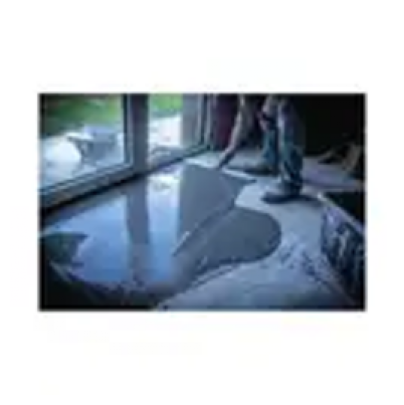

******************************************************


Predicted label: AMBIANCE	true label: AMBIANCE and proba: [0.61 0.13 0.26]


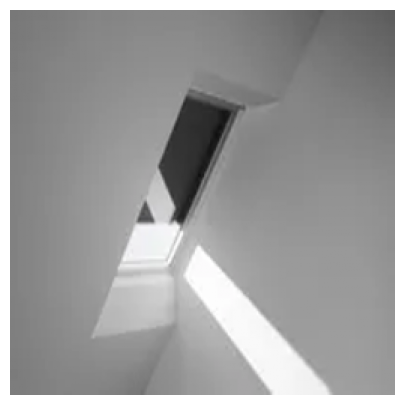

******************************************************


Predicted label: AMBIANCE	true label: AMBIANCE and proba: [0.64 0.22 0.14]


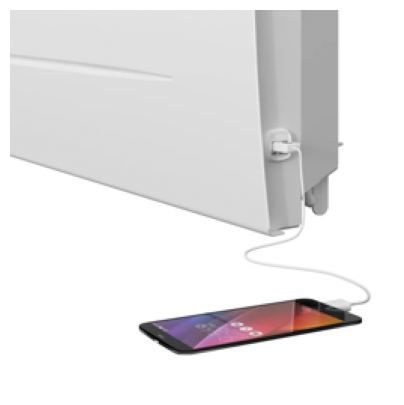

******************************************************


Predicted label: SKETCH	true label: SKETCH and proba: [0.1  0.25 0.65]


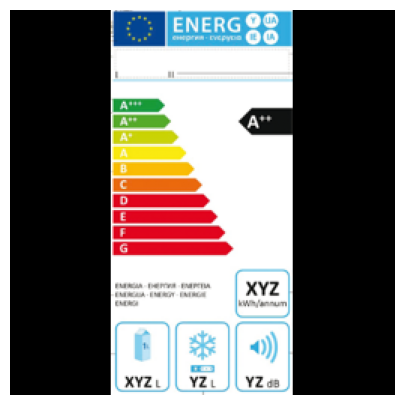

******************************************************


Predicted label: SKETCH	true label: SKETCH and proba: [0.1   0.316 0.584]


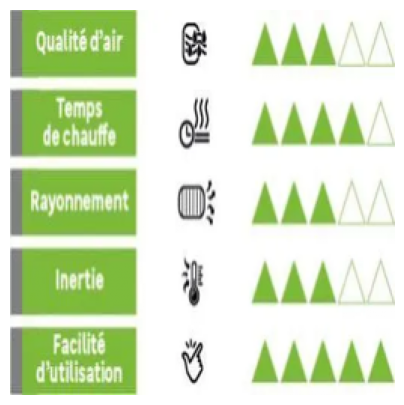

******************************************************


Predicted label: SKETCH	true label: SKETCH and proba: [0.28034483 0.07465517 0.645     ]


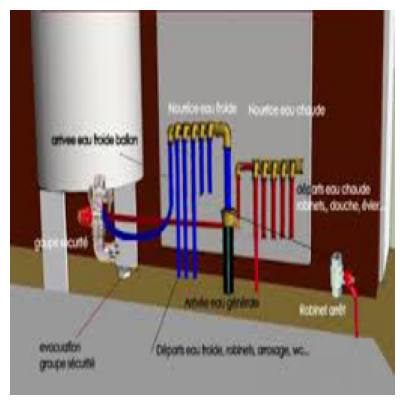

******************************************************




In [67]:
for i in wrong_detected.index:
    print(f"Predicted label: {preds[i]}\ttrue label: {wrong_detected.loc[i,'label']} and proba: {probs[i]}")
    plt.figure(figsize=(5,5))
    plt.imshow(load_pic(wrong_detected.loc[i,'path']))
    plt.axis("Off")
    plt.show()
    print("******************************************************\n\n")

## Test Set

Prediction: AMBIANCE, proba [0.72 0.24 0.04]


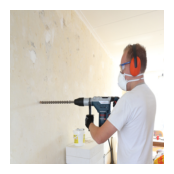

Prediction: PRODUCT, proba [0.1704 0.8196 0.01  ]


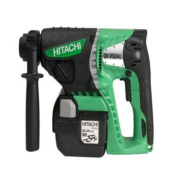

Prediction: AMBIANCE, proba [0.88 0.02 0.1 ]


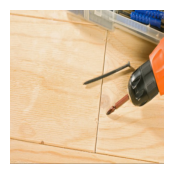

Prediction: SKETCH, proba [0. 0. 1.]


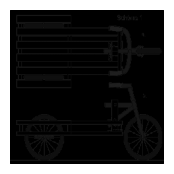

Prediction: PRODUCT, proba [0.23034483 0.64898851 0.12066667]
Confidence ration below threshold


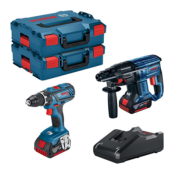

Prediction: PRODUCT, proba [0.19034483 0.66898851 0.14066667]


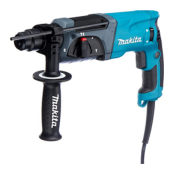

Prediction: PRODUCT, proba [0.21034483 0.69398851 0.09566667]


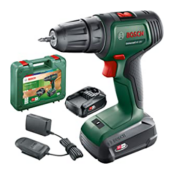

Prediction: AMBIANCE, proba [1. 0. 0.]


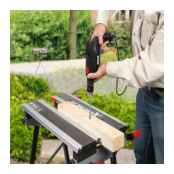

Prediction: AMBIANCE, proba [0.98 0.02 0.  ]


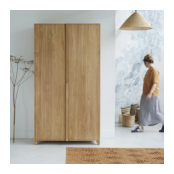

Prediction: SKETCH, proba [0. 0. 1.]


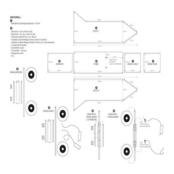

Prediction: PRODUCT, proba [0.0304 0.8896 0.08  ]


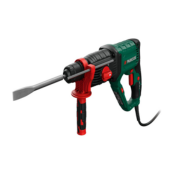

Prediction: AMBIANCE, proba [0.97 0.02 0.01]


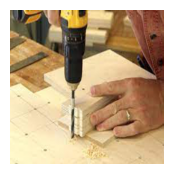

Prediction: AMBIANCE, proba [0.68034483 0.20965517 0.11      ]


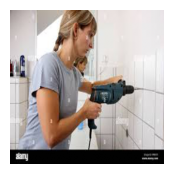

Prediction: AMBIANCE, proba [0.99 0.01 0.  ]


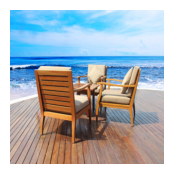

Prediction: SKETCH, proba [0.   0.03 0.97]


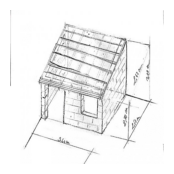

Prediction: PRODUCT, proba [0.0504 0.8796 0.07  ]


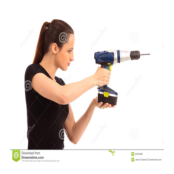

Prediction: PRODUCT, proba [6.54000000e-02 9.33766667e-01 8.33333333e-04]


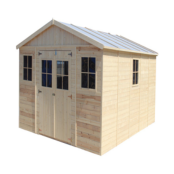

Prediction: SKETCH, proba [0.07 0.28 0.65]
Confidence ration below threshold


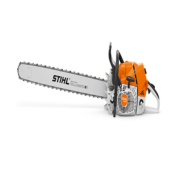

Prediction: AMBIANCE, proba [0.99 0.01 0.  ]


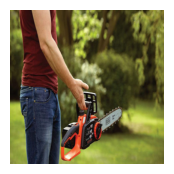

Prediction: SKETCH, proba [0.02076923 0.20839744 0.77083333]


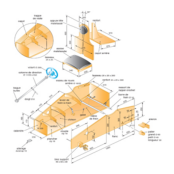

20 images in total


In [68]:
pred_test = classifier.predict(X_test)
test_probs = classifier.predict_proba(X_test)
for i in range(len(files)):
    print(f"Prediction: {pred_test[i]}, proba {test_probs[i]}")
    if np.max(test_probs[i])<= confidence_ratio:
        print("Confidence ration below threshold")
    pic = load_pic("test",files[i])
    plt.figure(figsize=(2,2))
    plt.imshow(pic)
    plt.axis("Off")
    plt.show()
print(len(files),"images in total")

<div class="alert alert-block alert-warning">
Random Forest is providing more reliable results. 95% accuracy on test set (if we accept the lady with a driller as a "product". The only error is the chainsaw where the confidence is low.
</div>


# Tensorflow

## with convolution
TF has too many learn parameters. We will limit the amount of convolutions

In [75]:
import tensorflow as tf

In [76]:
tf_data = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1,height_shift_range=0.1,
                                                shear_range=0.1, zoom_range=0.1,horizontal_flip=True,vertical_flip=False,
                                                rescale=1/255.0)
tf_data = tf_data.flow_from_directory(data_folder,
                                target_size=(256, 256),
                                class_mode='categorical')



Found 163 images belonging to 3 classes.


The learning rate is set really low as otherwise the algorithm does not even converge

In [77]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(2,3,activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3,activation='softmax')
])
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),loss='categorical_crossentropy',metrics=['accuracy'])

In [78]:
history = my_model.fit(tf_data,epochs=20)

Epoch 1/20
6/6 [==============================] - 3s 509ms/step - loss: 1.1102 - accuracy: 0.3620
Epoch 2/20
6/6 [==============================] - 3s 400ms/step - loss: 1.0616 - accuracy: 0.4233
Epoch 3/20
6/6 [==============================] - 3s 487ms/step - loss: 1.0752 - accuracy: 0.4233
Epoch 4/20
6/6 [==============================] - 3s 401ms/step - loss: 1.0242 - accuracy: 0.5215
Epoch 5/20
6/6 [==============================] - 3s 405ms/step - loss: 1.0562 - accuracy: 0.4356
Epoch 6/20
6/6 [==============================] - 3s 412ms/step - loss: 1.0107 - accuracy: 0.4724
Epoch 7/20
6/6 [==============================] - 2s 391ms/step - loss: 0.9621 - accuracy: 0.5828
Epoch 8/20
6/6 [==============================] - 3s 401ms/step - loss: 0.9721 - accuracy: 0.5767
Epoch 9/20
6/6 [==============================] - 3s 498ms/step - loss: 0.9260 - accuracy: 0.6135
Epoch 10/20
6/6 [==============================] - 2s 389ms/step - loss: 0.9262 - accuracy: 0.5890
Epoch 11/20
6/6 [==

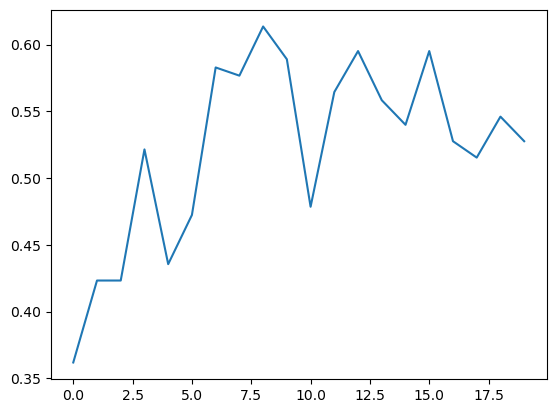

In [79]:
plt.plot(history.epoch,history.history['accuracy'])

In [80]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 2)       56        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 2)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32258)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 96777     
                                                                 
Total params: 96,833
Trainable params: 96,833
Non-trainable params: 0
_________________________________________________________________


<div class="alert alert-block alert-danger">
    Even with almost no convolution TF is in overfit
</div>

## without convolution

In [81]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3,activation='softmax')
])
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),loss='categorical_crossentropy',metrics=['accuracy'])

In [82]:
history = my_model.fit(tf_data,epochs=20)

Epoch 1/20
6/6 [==============================] - 2s 339ms/step - loss: 1.8928 - accuracy: 0.2761
Epoch 2/20
6/6 [==============================] - 2s 335ms/step - loss: 1.1765 - accuracy: 0.4049
Epoch 3/20
6/6 [==============================] - 2s 357ms/step - loss: 1.0601 - accuracy: 0.4110
Epoch 4/20
6/6 [==============================] - 2s 331ms/step - loss: 1.0039 - accuracy: 0.5153
Epoch 5/20
6/6 [==============================] - 2s 328ms/step - loss: 0.9947 - accuracy: 0.5215
Epoch 6/20
6/6 [==============================] - 2s 346ms/step - loss: 1.0288 - accuracy: 0.4908
Epoch 7/20
6/6 [==============================] - 2s 352ms/step - loss: 0.9541 - accuracy: 0.5521
Epoch 8/20
6/6 [==============================] - 2s 355ms/step - loss: 0.9519 - accuracy: 0.4969
Epoch 9/20
6/6 [==============================] - 2s 331ms/step - loss: 0.8891 - accuracy: 0.5951
Epoch 10/20
6/6 [==============================] - 2s 339ms/step - loss: 0.8590 - accuracy: 0.6012
Epoch 11/20
6/6 [==

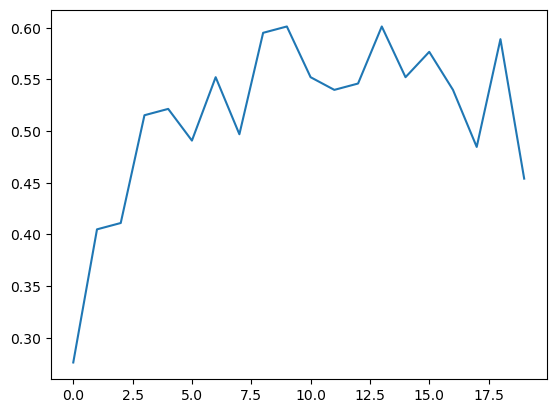

In [83]:
plt.plot(history.epoch,history.history['accuracy'])

In [84]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, None)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 589827    
                                                                 
Total params: 589,827
Trainable params: 589,827
Non-trainable params: 0
_________________________________________________________________
